 <div style="text-align:center;">
  # <span style="color:green; font-size:larger; font-weight:bold;">Vérification de la loi d'Okun dans plusieurs pays du monde</span><br><br>
  <span style="font-weight:bold;">Présenté par:</span><br>
  <span>NOUBOUSSI GNINTEDEM LUCIE MARIMAR</span><br>
  <span>YOUSRA JEDDOUB</span> <br>
  <span>AMINA MANSEUR</span>
</div>



<span style="color:green; font-size:larger; font-weight:bold;">INTRODUCTION</span>

FAIRE UNE INTRODCUTION

# <span style="color:green">I- Importation et installation des packages</span>

In [ ]:
""" %pip install numpy
%pip install pandas
%pip install matplotlib
%pip install openpyxl
%pip install pycodestyle
%pip install pycountry
%pip install seaborn
%pip install pickleshare
%pip install tensorflow==2.7.0 
%pip install scikit-learn"""


In [2]:

import pycodestyle as pep8
import zipfile
import requests
import openpyxl as xl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycountry
import seaborn as sns
import missingno as msno
import io
from io import BytesIO


np.random.seed(123)

In [ ]:
def extraire_fichier_zip(chemin_zip, nom_fichier):
    with zipfile.ZipFile(chemin_zip, 'r') as zip_ref:
        with zip_ref.open(nom_fichier) as fichier_in_zip:
            return pd.read_excel(BytesIO(fichier_in_zip.read()), header=0)\
                        .rename(columns={'Unnamed: 0':'Year'})\
                            .assign(Year=lambda x: x['Year'].astype(str).str.rstrip('.0'))

# <span style="color:green; ">II- Construction de la base de données</span>

il faut faire une explication de toutes lés étapes que nous allons faire pour constituer notre base 

## <span style="color:green; text-align:center;">II-1 Importation de la base GemDataEXTR.Zip via son url de téléchargement</span>

In [ ]:
url = "https://datacatalogfiles.worldbank.org/ddh-published/0037798/DR0092042/GemDataEXTR.zip?"

# Télécharger le fichier
response = requests.get(url)

# Vérifier si le téléchargement a réussi (code d'état 200)
if response.status_code == 200:
    # Enregistrer le contenu dans un fichier  ( "GemDataEXTR.zip")
    with open("GemDataEXTR.zip", 'wb') as file:
        file.write(response.content)
    print("Téléchargement réussi.")
else:
    print(f"Erreur de téléchargement : {response.status_code}")


In [ ]:
#definition d'une fonction d'extraction de base dans un fichier zippé

def extraire_fichier_zip(chemin_zip, nom_fichier,nom_feuille):
    with zipfile.ZipFile(chemin_zip, 'r') as zip_ref:
        with zip_ref.open(nom_fichier) as fichier_in_zip:
            return pd.read_excel(BytesIO(fichier_in_zip.read()),sheet_name=nom_feuille, header=0)\
                        .rename(columns={'Unnamed: 0':'Year'})\
                            .assign(Year=lambda x: x['Year'].astype(str).str.rstrip('.0'))

                            
fichier_zip = 'GemDataEXTR.zip'

# Choix des fichiers à extraire

nom_fichiers=[ ('Unemployment Rate, seas. adj..xlsx', 'monthly'),
              ('GDP Deflator at Market Prices, LCU.xlsx', 'quarterly')
]

# Extraction des bases dans la mémoire: chomage et PIB déflaté
df_Unemployement, df_GDP= [extraire_fichier_zip(fichier_zip, nom_fichier, nom_feuille)
                           for nom_fichier, nom_feuille in nom_fichiers]

L'extraction des données sur le taux de chômage et le PIB déflaté par pays est désormais complète. <br>
Dans la prochaine étape, nous procéderons à une exploration rapide de ces données et les fusionnerons pour une analyse plus approfondie.


### <span style="color:green; text-align:center;">II-1-1 Préparation des bases avant fusion</span>

#### <span style="color:green; text-align:center;">II-1-1-1 Base taux de chômage</span>

In [ ]:
df_Unemployement.head()

In [ ]:
#type des données
df_Unemployement.info()


Le type de chaque variable est approprié et correspond aux types attendus.

##### Detections des doublons

In [ ]:
#vérification des doublons
print("Nombre total de doublons dans df_Unemployement :", 
      df_Unemployement[df_Unemployement.duplicated()].shape[0])

##### Corrections des noms des pays

In [ ]:
# Méthode search_fuzzy de pycountry 
def correct_country_name(col_names):
    countries_detected = []
    
    for name in col_names:
        try:
            # Essayer de trouver le pays par son nom
            pays= pycountry.countries.search_fuzzy(name)[0]
            countries_detected.append(pays.name)
        except LookupError:
            # Conserver les noms qui ne correspondent à aucun pays
            countries_detected.append(name)
    
    return countries_detected

# Appliquer la correction sur chaque colonne du DataFrame
df_Unemployement.columns=correct_country_name(df_Unemployement.columns)

In [ ]:
# verifions que le nom des colonnes correspond bien à celui d'un pays
# Méthode search_fuzzy de pycountry 

def detect_countries(col_names):
    countries_detected = []
    
    for name in col_names:
        try:
            # Essayer de trouver le pays par son nom
            pays= pycountry.countries.search_fuzzy(name)[0]
            countries_detected.append(pays.name)
        except LookupError:
            # Ignorer les noms qui ne correspondent à aucun pays
            pass
    
    return countries_detected


pays=detect_countries(df_Unemployement.columns)
print("La liste des pays présents dans la base est la suivante: \n ", pays)

In [ ]:
print("Liste des colonnes qui sont dans la base et qui ne representent pas les pays")
list(set(df_Unemployement.columns) - set(pays))

commentaire: La méthode n'a pas pu extraire tous les pays du fait de  leur nomenclature.<br> 
Ainsi, nous allons ajouter ceux de façon manuelle à la listes des pays déjà selectionnés.

In [ ]:
#listes des pays nonpris ne compte du fait de leur nomenclature
pays1=['Year','Venezuela, RB', 'Turkey', 'Korea, Rep.','Egypt, Arab Rep.',
      'Taiwan, China','Hong Kong SAR, China']

# conservation uniquement des pays dans la base 
df_Unemployement=df_Unemployement[pays1+pays]

##### Detections des valeurs manquantes

In [ ]:
#%pip install missingno

In [ ]:
# Visualisation des valeurs manquantes NA

# Diagramme à barres des valeurs manquantes
msno.bar(df_Unemployement)
plt.show()
# visualisation 2
sns.heatmap(df_Unemployement.isna(), cbar=False)
plt.show()

Les données sont des séries temporelles.<br>
Grâce à la visualisation 2, on constate que pour la plupart des pays,<br>
les valeurs manquantes sont en début de periode d'obervation d'observation.<br>
Ainsi, nous allons garder les pays avec au moins 60% des observations non manquantes.

In [ ]:
## affichage du pourcentage de valeurs manquantes par pays pour des pays ayant des valeurs manquantes

(df_Unemployement.isna().sum() / len(df_Unemployement) * 100)[df_Unemployement.isna().any()].sort_values(ascending=False)

In [ ]:
# Suppression de certaines valeurs manquantes

df_Unemployement.dropna(axis=1, thresh=len(df_Unemployement) * 0.6, inplace=True)

(df_Unemployement.isna().sum() / len(df_Unemployement) * 100)[df_Unemployement.isna().any()].sort_values(ascending=False)

In [ ]:
# Visualisation des valeurs manquantes NA

# Diagramme à barres des valeurs manquantes
msno.bar(df_Unemployement)
plt.show()

sns.heatmap(df_Unemployement.isna(), cbar=False)
plt.show()

#### Imputation des valeurs manquantes

In [ ]:
df_Unemployement.head()

In [ ]:

## supression des deux premières lignes car nous allons commencer en 1994

df_Unemployement=df_Unemployement.drop([df_Unemployement.index[0], df_Unemployement.index[1]])


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Générer une série temporelle avec du bruit
np.random.seed(42)
n_obs = 100
epsilon = np.random.normal(size=n_obs)
y = np.zeros(n_obs)

for t in range(1, n_obs):
    y[t] = 0.7 * y[t-1] + epsilon[t]

# Afficher la série temporelle
plt.plot(y)
plt.title('Série temporelle avec du bruit')
plt.show()

# Ajuster un modèle ARMA(p, q)
p, q = 1, 1
model = sm.tsa.ARMA(y, order=(p, q))
results = model.fit()

# Afficher les résultats du modèle
print(results.summary())

# Prévoir les prochaines valeurs
forecast_steps = 10
forecast, stderr, conf_int = results.forecast(steps=forecast_steps)

# Afficher les prévisions
plt.plot(np.arange(n_obs), y, label='Observations')
plt.plot(np.arange(n_obs, n_obs + forecast_steps), forecast, label='Prévisions')
plt.fill_between(np.arange(n_obs, n_obs + forecast_steps), conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label='Intervalle de confiance')
plt.title('Prévisions avec un modèle ARMA')
plt.legend()
plt.show()


# Taux de chômage

# Importation de la BD

In [3]:
rate=pd.read_excel("C:/Users/yousr/Downloads/Projet_py/Unemployment Rate.xlsx", sheet_name='monthly' , index_col=0 )
rate.head(5)
rate.index = pd.to_datetime(rate.index,format='%YM%m')
rate.index =rate.index.strftime('%Y-%m')

In [4]:
# Noms des colonnes
col_names=rate.columns
print(col_names)

Index(['Advanced Economies', 'Argentina', 'Australia', 'Austria', 'Belgium',
       'Bulgaria', 'Bahrain', 'Belarus', 'Brazil', 'Canada', 'Switzerland',
       'Chile', 'Colombia', 'Cyprus', 'Czech Republic', 'Germany', 'Denmark',
       'Dominican Republic', 'Algeria', 'EMDE East Asia & Pacific',
       'EMDE Europe & Central Asia', 'Ecuador', 'Egypt, Arab Rep.',
       'Emerging Market and Developing Economies (EMDEs)', 'Spain', 'Estonia',
       'Finland', 'France', 'United Kingdom', 'Greece',
       'High Income Countries', 'Hong Kong SAR, China', 'Croatia', 'Hungary',
       'Ireland', 'Iceland', 'Israel', 'Italy', 'Japan', 'Korea, Rep.',
       'EMDE Latin America & Caribbean', 'Low-Income Countries (LIC)',
       'Sri Lanka', 'Lithuania', 'Luxembourg', 'Latvia', 'Morocco', 'Mexico',
       'Middle-Income Countries (MIC)', 'North Macedonia', 'Malta',
       'EMDE Middle East & N. Africa', 'Netherlands', 'Norway', 'New Zealand',
       'Pakistan', 'Peru', 'Philippines', 'Poland', 

# Type de données

In [5]:
# Type de données de chaque colonne 
datas_type= rate.dtypes
print(datas_type)  # Il s'agit de données de type float

Advanced Economies     float64
Argentina              float64
Australia              float64
Austria                float64
Belgium                float64
                        ...   
United States          float64
Venezuela, RB          float64
Viet Nam               float64
World (WBG members)    float64
South Africa           float64
Length: 79, dtype: object


# Doublons

In [6]:
duplicates = rate[rate.duplicated()]
duplicates.head(5) # 0 doublons dans notre DF

,Advanced Economies,Argentina,Australia,Austria,Belgium,Bulgaria,Bahrain,Belarus,Brazil,Canada,...,Thailand,Tunisia,Turkey,"Taiwan, China",Uruguay,United States,"Venezuela, RB",Viet Nam,World (WBG members),South Africa


# Erreurs de frappes pour la colonne index

In [7]:
rate.index = pd.to_datetime(rate.index, errors='coerce')
errors = rate[rate.index.isnull()]
errors.head(10) # Pas d'erreurs #########################################################################################

,Advanced Economies,Argentina,Australia,Austria,Belgium,Bulgaria,Bahrain,Belarus,Brazil,Canada,...,Thailand,Tunisia,Turkey,"Taiwan, China",Uruguay,United States,"Venezuela, RB",Viet Nam,World (WBG members),South Africa


# Construction de DF

In [8]:
# Garder uniquement les pays dans la DF : Méthode search_fuzzy de pycountry ###############################################################

def detect_countries(col_names):
    countries_detected = []
    
    for name in col_names:
        try:
            # Essayer de trouver le pays par son nom
            pays= pycountry.countries.search_fuzzy(name)[0]
            countries_detected.append(pays.name)
        except LookupError:
            # Ignorer les noms qui ne correspondent à aucun pays
            pass
    
    return countries_detected

# Liste des pays detectés

countries_detected = detect_countries(col_names)
print("Noms de pays détectés :", countries_detected)

# Longeur des listes : countries_detected et col_names
print(len(countries_detected))
print(len(col_names))

# Différence entre les deux listes pour obtenir les noms des colonnes ignorées par la fonction detect_countries
#L'objectif est de vérifier si des pays ont été omis par la fonction detect_countries

# Pays dans col_names et pas dans countries_detected
diff= list(set(col_names) - set(countries_detected))
print(diff) 

# Pays dans countries_detected et pas dans col_names
diff2= list(set(countries_detected)- set(col_names))
print(diff2)

countries_omitted =['Korea, Rep.', 'Taiwan, China', 'Hong Kong SAR, China', 'Czech Republic', 'Egypt, Arab Rep.', 'Venezuela, RB'] ####################""
concat = countries_detected + countries_omitted 

# Enfin, la liste finale des pays à retenir dans la DF
countries_detected =list(set(concat)- set(diff2))
print(countries_detected)

# La DF taux de chomage à retenir après avoir filtré les pays
rate_filter= rate[countries_detected]
rate_filter.columns

Noms de pays détectés : ['Argentina', 'Australia', 'Austria', 'Belgium', 'Bulgaria', 'Bahrain', 'Belarus', 'Brazil', 'Canada', 'Switzerland', 'Chile', 'Colombia', 'Cyprus', 'Czechia', 'Germany', 'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Spain', 'Estonia', 'Finland', 'France', 'United Kingdom', 'Greece', 'Croatia', 'Hungary', 'Ireland', 'Iceland', 'Israel', 'Italy', 'Japan', 'Sri Lanka', 'Lithuania', 'Luxembourg', 'Latvia', 'Morocco', 'Mexico', 'North Macedonia', 'Malta', 'Netherlands', 'Norway', 'New Zealand', 'Pakistan', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russian Federation', 'Saudi Arabia', 'Singapore', 'Slovakia', 'Slovenia', 'Sweden', 'Thailand', 'Tunisia', 'Turkey', 'Uruguay', 'United States', 'Viet Nam', 'South Africa']
62
79
['Egypt, Arab Rep.', 'Hong Kong SAR, China', 'EMDE Latin America & Caribbean', 'Taiwan, China', 'EMDE Europe & Central Asia', 'Emerging Market and Developing Economies (EMDEs)', 'EMDE East Asia & Pacific', 'EMDE Sub-Sahara

Index(['Ecuador', 'Tunisia', 'Czech Republic', 'Algeria', 'South Africa',
       'Turkey', 'Korea, Rep.', 'Russian Federation', 'United Kingdom',
       'Egypt, Arab Rep.', 'Romania', 'Saudi Arabia', 'Singapore', 'Israel',
       'Estonia', 'Cyprus', 'Iceland', 'Portugal', 'Sweden', 'Slovakia',
       'Germany', 'Canada', 'Switzerland', 'Sri Lanka', 'New Zealand',
       'Uruguay', 'Finland', 'Norway', 'United States', 'Argentina', 'Belgium',
       'Morocco', 'Latvia', 'Colombia', 'Netherlands', 'Dominican Republic',
       'Chile', 'Poland', 'Austria', 'Spain', 'Thailand', 'North Macedonia',
       'Bahrain', 'France', 'Hong Kong SAR, China', 'Taiwan, China',
       'Philippines', 'Italy', 'Luxembourg', 'Peru', 'Malta', 'Venezuela, RB',
       'Hungary', 'Belarus', 'Slovenia', 'Australia', 'Ireland', 'Pakistan',
       'Bulgaria', 'Greece', 'Japan', 'Croatia', 'Brazil', 'Denmark', 'Mexico',
       'Lithuania', 'Viet Nam'],
      dtype='object')

In [9]:
# Pour faciliter la lecture de la DF, on remplace les noms des pays par leurs codes ISO correspondant

# Dictionnaire de correspondance entre noms complets des pays et leurs codes
corresp = {country.name: country.alpha_3 for country in pycountry.countries}

# Liste initiale des noms complets des colonnes
country = countries_detected
# Transformation des noms complets des colonnes en abréviations
country_codes = [corresp.get(pays, pays) for pays in country]

# Remplacement des noms des pays par leurs codes dans la merged
rate_filter.columns=country_codes
rate_filter.columns
rate_filter.head(5)

#Ordre alphabétique des colonnes 
rate_filter_sort= rate_filter.sort_index(axis=1)
rate_filter_sort.head(5)

,ARG,AUS,AUT,BEL,BGR,BHR,BLR,BRA,CAN,CHE,...,SWE,THA,TUN,TUR,"Taiwan, China",URY,USA,VNM,"Venezuela, RB",ZAF
1993-12-01,NaN,10.66106,6.869156,9.450078,16.08,NaN,NaN,NaN,11.4,4.967008,...,11.36529,NaN,NaN,NaN,1.3,NaN,6.5,NaN,NaN,NaN
1994-01-01,NaN,10.58005,6.672157,9.518617,15.86,NaN,NaN,NaN,11.4,4.847199,...,11.26787,NaN,NaN,NaN,1.4,NaN,6.6,NaN,NaN,NaN
1994-02-01,NaN,10.36909,6.637267,9.631846,15.67,NaN,NaN,NaN,11.1,4.870878,...,11.13366,NaN,NaN,NaN,1.7,NaN,6.6,NaN,NaN,NaN
1994-03-01,NaN,10.33146,6.425844,9.716527,15.49,NaN,NaN,NaN,10.6,4.837618,...,10.84779,NaN,NaN,NaN,1.6,NaN,6.5,NaN,NaN,NaN
1994-04-01,NaN,10.10692,6.683679,9.837231,15.02,NaN,NaN,NaN,10.9,4.809402,...,10.61952,NaN,NaN,NaN,1.6,NaN,6.4,NaN,NaN,NaN


# Visualisation des NA

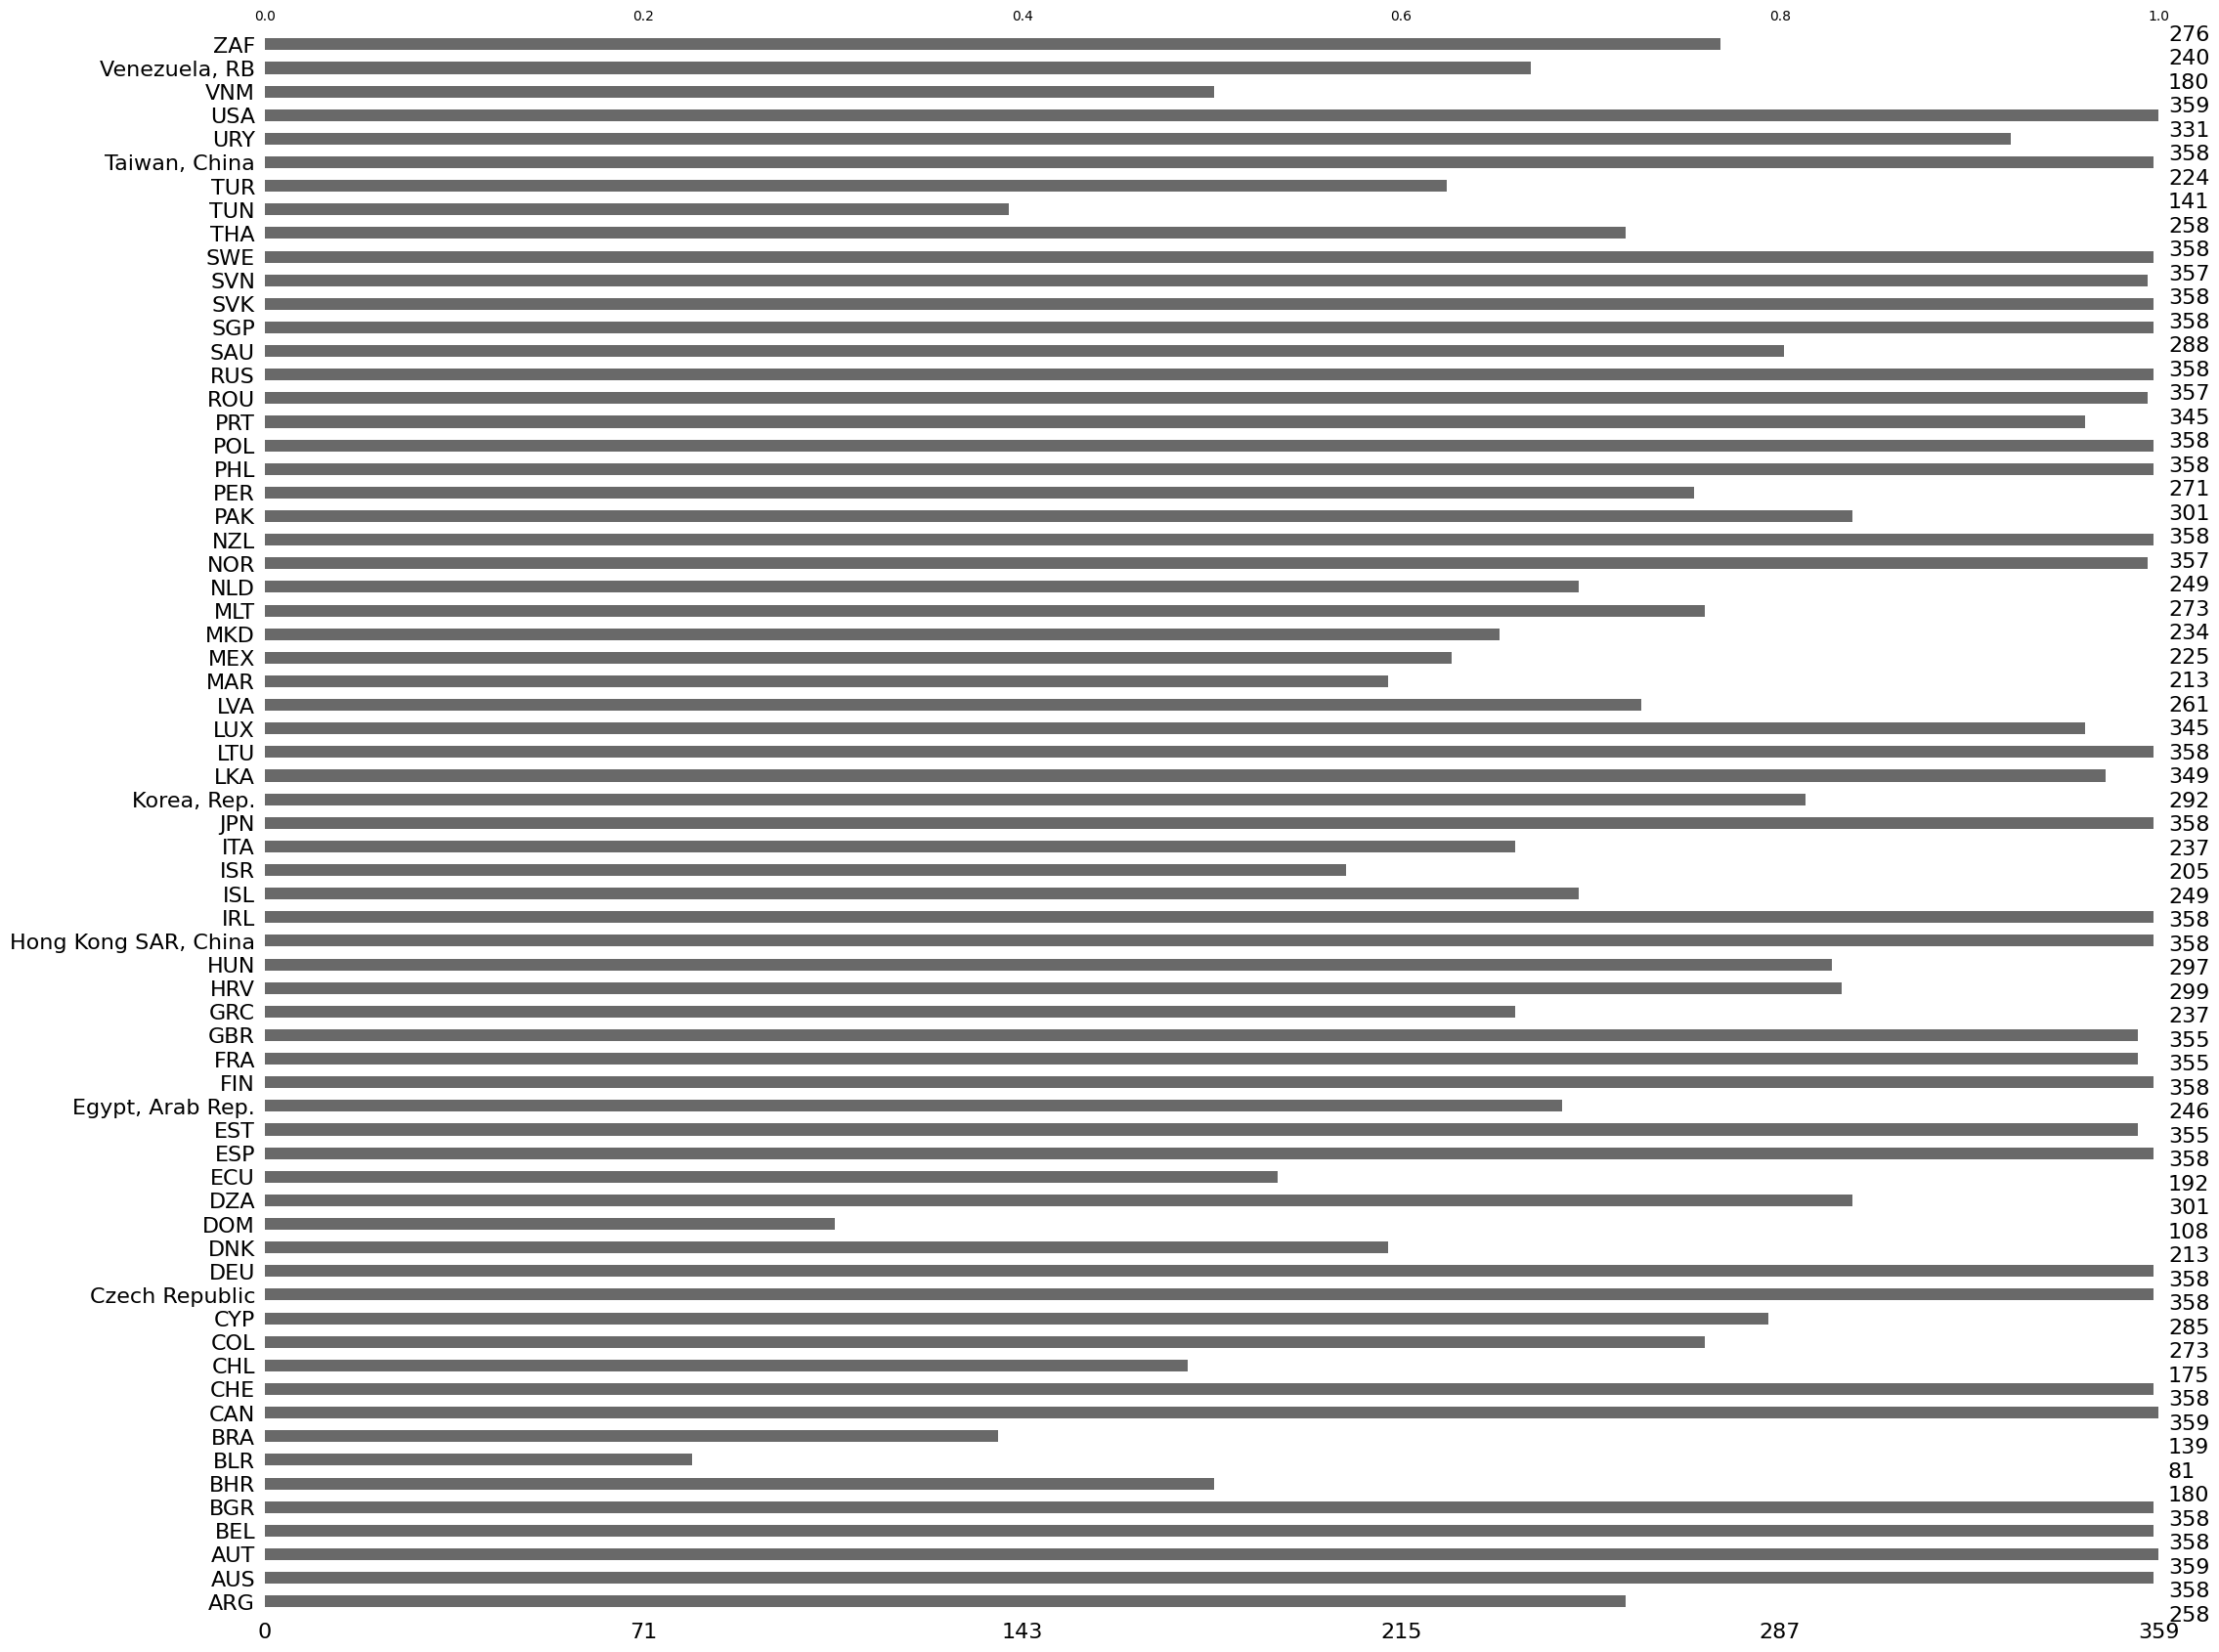

In [10]:
# Visualisation des valeurs manquantes NA
import missingno as msno
# Diagramme à barres des valeurs manquantes
msno.bar(rate_filter_sort)
plt.show()

# % des NA

In [11]:
# Calculer le pourcentage de valeurs manquantes dans chaque colonne
size = rate_filter_sort.shape
nan_sum = rate_filter_sort.isna().sum() # Total du nombre de NA par colonne
nan_percent = nan_sum.sort_values(ascending=True) * 100 / size[0]
print(nan_percent)

AUT     0.000000
USA     0.000000
CAN     0.000000
JPN     0.278552
LTU     0.278552
         ...    
CHL    51.253482
TUN    60.724234
BRA    61.281337
DOM    69.916435
BLR    77.437326
Length: 67, dtype: float64


# Seuil des NA

In [12]:
# Récupérer les colonnes avec un pourcentage de valeurs manquantes supérieur à 40%
cols_to_drop = nan_percent[nan_percent > 40].index
print(cols_to_drop)

# Supprimer les colonnes de la DataFrame
rate_filter_sort.drop(cols_to_drop, axis=1, inplace=True)

Index(['DNK', 'MAR', 'ISR', 'ECU', 'BHR', 'VNM', 'CHL', 'TUN', 'BRA', 'DOM',
       'BLR'],
      dtype='object')


In [13]:
# Type de données de chaque colonne 
data_type = rate_filter_sort.dtypes
print(data_type) # Toutes les colonnes sont de type float64

ARG                     float64
AUS                     float64
AUT                     float64
BEL                     float64
BGR                     float64
CAN                     float64
CHE                     float64
COL                     float64
CYP                     float64
Czech Republic          float64
DEU                     float64
DZA                     float64
ESP                     float64
EST                     float64
Egypt, Arab Rep.        float64
FIN                     float64
FRA                     float64
GBR                     float64
GRC                     float64
HRV                     float64
HUN                     float64
Hong Kong SAR, China    float64
IRL                     float64
ISL                     float64
ITA                     float64
JPN                     float64
Korea, Rep.             float64
LKA                     float64
LTU                     float64
LUX                     float64
LVA                     float64
MEX     

# Imputation

In [14]:
# Imputation des NA

#rate_filter_sort_inter=rate_filter_sort.interpolate(method='linear', axis=0, limit=None, inplace=False, limit_direction=None, limit_area=None)

#rate_filter_sort.fillna(value=None, method='ffill', axis=None, inplace=False, limit=None)

rate_no_na = rate_filter_sort.fillna(rate_filter_sort.mean())

#rate_filter_sort_fill= rate_filter_sort.iloc[-5:].ffill()

indice_premiere_na = rate_filter_sort.isna().any(axis=1).idxmax()
print(indice_premiere_na)

#numero_ligne = rate_filter_sort.index.get_loc(indice_premiere_na) + 1
"""
from datetime import datetime
date_today = datetime.now()

# Extrait l'année de la date actuelle
current_year = date_today.year
str(current_year)
rate_filter_sort.index = pd.to_datetime(rate_filter_sort.index, format='mixed')


rate_filter_sort.index = rate_filter_sort.index.astype(str)
rate_current_year = rate_filter_sort[rate_filter_sort.index.str.contains(current_year)]


#rate_filter_sort.index = pd.to_datetime(rate_filter_sort.index)

#year2023 =rate_filter_sort.loc[rate_filter_sort.index.year == 2023]

#.fillna(rate_filter_sort.mean())
print(rate_filter_sort.index.dtype) """

1993-12-01 00:00:00


"\nfrom datetime import datetime\ndate_today = datetime.now()\n\n# Extrait l'année de la date actuelle\ncurrent_year = date_today.year\nstr(current_year)\nrate_filter_sort.index = pd.to_datetime(rate_filter_sort.index, format='mixed')\n\n\nrate_filter_sort.index = rate_filter_sort.index.astype(str)\nrate_current_year = rate_filter_sort[rate_filter_sort.index.str.contains(current_year)]\n\n\n#rate_filter_sort.index = pd.to_datetime(rate_filter_sort.index)\n\n#year2023 =rate_filter_sort.loc[rate_filter_sort.index.year == 2023]\n\n#.fillna(rate_filter_sort.mean())\nprint(rate_filter_sort.index.dtype) "

# Valeurs abérrantes

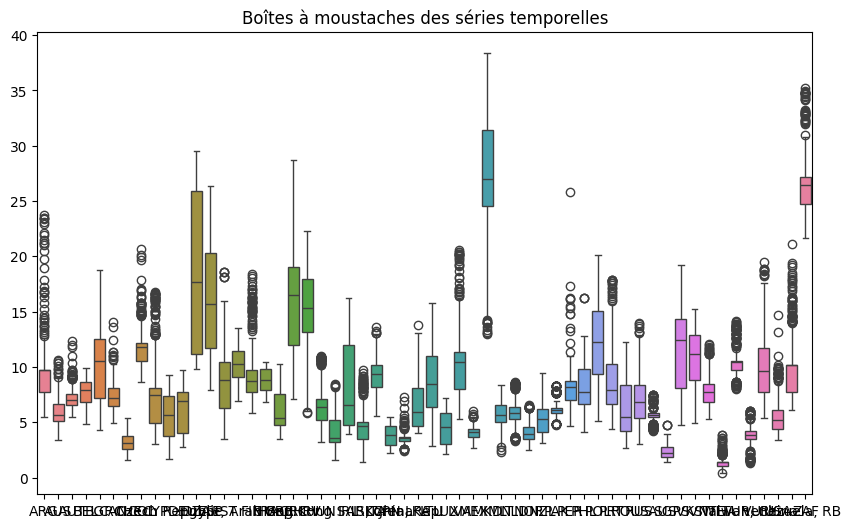

In [15]:
# Les valeurs abérrantes 
plt.figure(figsize=(10, 6))
sns.boxplot(data=rate_no_na)
plt.title('Boîtes à moustaches des séries temporelles')
plt.show()

# Ajustement

In [16]:
rate_no_na.index = pd.to_datetime(rate_no_na.index, format='%Y-%m-%d')

# Grouper par année et vérifier si tous les mois sont présents
rate_12= rate_no_na.groupby(rate_no_na.index.year).filter(lambda x: len(x) == 12)
rate_12= pd.DataFrame(rate_12)
rate_12.head(5)

,ARG,AUS,AUT,BEL,BGR,CAN,CHE,COL,CYP,Czech Republic,...,SVK,SVN,SWE,THA,TUR,"Taiwan, China",URY,USA,"Venezuela, RB",ZAF
1994-01-01,9.724381,10.580050,6.672157,9.518617,15.86,11.4,4.847199,11.808516,7.71193,4.2,...,14.49,15.1,11.26787,1.380426,10.480357,1.4,9.929305,6.6,10.204788,26.474568
1994-02-01,9.724381,10.369090,6.637267,9.631846,15.67,11.1,4.870878,11.808516,7.71193,4.2,...,14.31,15.1,11.13366,1.380426,10.480357,1.7,9.929305,6.6,10.204788,26.474568
1994-03-01,9.724381,10.331460,6.425844,9.716527,15.49,10.6,4.837618,11.808516,7.71193,4.0,...,14.45,15.0,10.84779,1.380426,10.480357,1.6,9.929305,6.5,10.204788,26.474568
1994-04-01,9.724381,10.106920,6.683679,9.837231,15.02,10.9,4.809402,11.808516,7.71193,4.4,...,14.52,14.8,10.61952,1.380426,10.480357,1.6,9.929305,6.4,10.204788,26.474568
1994-05-01,9.724381,9.833122,6.609101,9.949417,14.73,10.7,4.808228,11.808516,7.71193,4.2,...,14.62,14.7,10.62802,1.380426,10.480357,1.5,9.929305,6.1,10.204788,26.474568


# Regroupement

In [17]:
# Transformer les données mensuelles en données trimestrielles
rate_quart = rate_12.resample('Q-JAN').mean()
#print(rate_quart)

In [18]:
# Ignorer les jours dans l'index
rate_quart.index =rate_quart.index.strftime('%Y-%m')

# BD des taux de chomage par trimestre pour chaque pays

In [19]:
rate_quart.head(5) #56 pays 

,ARG,AUS,AUT,BEL,BGR,CAN,CHE,COL,CYP,Czech Republic,...,SVK,SVN,SWE,THA,TUR,"Taiwan, China",URY,USA,"Venezuela, RB",ZAF
1994-01,9.724381,10.580050,6.672157,9.518617,15.860000,11.400000,4.847199,11.808516,7.71193,4.200000,...,14.490000,15.100000,11.267870,1.380426,10.480357,1.400000,9.929305,6.600000,10.204788,26.474568
1994-04,9.724381,10.269157,6.582263,9.728535,15.393333,10.866667,4.839299,11.808516,7.71193,4.200000,...,14.426667,14.966667,10.866990,1.380426,10.480357,1.633333,9.929305,6.500000,10.204788,26.474568
1994-07,9.724381,9.745672,6.553856,9.881526,14.143333,10.366667,4.786481,11.808516,7.71193,4.266667,...,14.716667,14.566667,10.881637,1.380426,10.480357,1.533333,9.929305,6.100000,10.204788,26.474568
1994-10,9.724381,9.289072,6.553429,9.773351,13.103333,10.100000,4.664329,11.808516,7.71193,4.400000,...,14.720000,14.300000,10.628213,1.380426,10.480357,1.566667,9.929305,5.900000,10.204788,26.474568
1995-01,9.724381,8.934670,6.435007,9.673261,12.460000,9.633333,4.412043,11.808516,7.71193,4.266667,...,14.650000,13.966667,10.443377,1.380426,10.480357,1.600000,9.929305,5.566667,10.204788,26.474568


# II. PIB

In [20]:
#%pip install missingno
import pycodestyle as pep8
import openpyxl as xl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycountry
import missingno as msno
import seaborn as sns
np.random.seed(123)

# Importation 

In [21]:
# Importation du fichier .xlsx
gdp=pd.read_excel("C:/Users/yousr/Downloads/Projet_py/GDP Deflator at Market Prices, LCU.xlsx",  sheet_name='quarterly', index_col=0)
gdp.head(5)
gdp.index = pd.to_datetime(gdp.index)
gdp.index =gdp.index.strftime('%Y-%m')

C:\Users\yousr\AppData\Local\Temp\ipykernel_2120\727520486.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gdp.index = pd.to_datetime(gdp.index)


In [22]:
# Noms des colonnes
col_names=gdp.columns
print(col_names)

Index(['Albania', 'Argentina', 'Australia', 'Austria', 'Belgium', 'Bulgaria',
       'Bahrain', 'Bosnia and Herzegovina', 'Belarus', 'Bolivia', 'Brazil',
       'Botswana', 'Canada', 'Switzerland', 'Chile', 'China', 'Cameroon',
       'Colombia', 'Costa Rica', 'Cyprus', 'Czech Republic', 'Germany',
       'Denmark', 'Ecuador', 'Egypt, Arab Rep.', 'Spain', 'Estonia', 'Finland',
       'France', 'United Kingdom', 'Ghana', 'Greece', 'Guatemala',
       'Hong Kong SAR, China', 'Honduras', 'Croatia', 'Hungary', 'Indonesia',
       'India', 'Ireland', 'Iceland', 'Israel', 'Italy', 'Jordan', 'Japan',
       'Kazakhstan', 'Kenya', 'Korea, Rep.', 'Kuwait', 'Sri Lanka',
       'Lithuania', 'Luxembourg', 'Latvia', 'Morocco', 'Mexico',
       'North Macedonia', 'Malta', 'Mongolia', 'Malaysia', 'Nigeria',
       'Nicaragua', 'Netherlands', 'Norway', 'New Zealand', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Paraguay', 'Romania',
       'Russian Federation', 'Saudi Arabia', 'Singapore', 'Se

# Type de données

In [23]:
# Type de données de chaque colonne 
datas_type= gdp.dtypes
print(datas_type)  # Données de type float

Albania          float64
Argentina        float64
Australia        float64
Austria          float64
Belgium          float64
                  ...   
Taiwan, China    float64
Ukraine          float64
Uruguay          float64
United States    float64
South Africa     float64
Length: 85, dtype: object


# Doublons

In [24]:
duplicates = gdp[gdp.duplicated()]
duplicates.head(5) # 0 doublons dans notre gdp_no_na

,Albania,Argentina,Australia,Austria,Belgium,Bulgaria,Bahrain,Bosnia and Herzegovina,Belarus,Bolivia,...,Slovenia,Sweden,Thailand,Tunisia,Turkey,"Taiwan, China",Ukraine,Uruguay,United States,South Africa


# Erreurs de frappes pour la colonne index

In [25]:
gdp.index = pd.to_datetime(gdp.index, errors='coerce')
errors = gdp[gdp.index.isnull()]
print(errors) # Pas d'erreurs

Empty DataFrame
Columns: [Albania, Argentina, Australia, Austria, Belgium, Bulgaria, Bahrain, Bosnia and Herzegovina, Belarus, Bolivia, Brazil, Botswana, Canada, Switzerland, Chile, China, Cameroon, Colombia, Costa Rica, Cyprus, Czech Republic, Germany, Denmark, Ecuador, Egypt, Arab Rep., Spain, Estonia, Finland, France, United Kingdom, Ghana, Greece, Guatemala, Hong Kong SAR, China, Honduras, Croatia, Hungary, Indonesia, India, Ireland, Iceland, Israel, Italy, Jordan, Japan, Kazakhstan, Kenya, Korea, Rep., Kuwait, Sri Lanka, Lithuania, Luxembourg, Latvia, Morocco, Mexico, North Macedonia, Malta, Mongolia, Malaysia, Nigeria, Nicaragua, Netherlands, Norway, New Zealand, Peru, Philippines, Poland, Portugal, Paraguay, Romania, Russian Federation, Saudi Arabia, Singapore, Serbia, Slovakia, Slovenia, Sweden, Thailand, Tunisia, Turkey, Taiwan, China, Ukraine, Uruguay, United States, South Africa]
Index: []

[0 rows x 85 columns]


# Construction de la DF

In [26]:
# Garder uniquement les pays dans la gdp_filter_sort : Méthode search_fuzzy de pycountry ###############################################################

def detect_countries(col_names):
    countries_detected = []
    
    for name in col_names:
        try:
            # Essayer de trouver le pays par son nom
            pays= pycountry.countries.search_fuzzy(name)[0]
            countries_detected.append(pays.name)
        except LookupError:
            # Ignorer les noms qui ne correspondent à aucun pays
            pass
    
    return countries_detected

# Liste des pays detectés

countries_detected = detect_countries(col_names)
print("Noms de pays détectés :", countries_detected)

# Longeur des listes : countries_detected et col_names
print(len(countries_detected))
print(len(col_names))

# Différence entre les deux listes pour obtenir les noms des colonnes ignorées par la fonction detect_countries
#L'objectif est de vérifier si des pays ont été omis par la fonction detect_countries

# Pays dans col_names et pas dans countries_detected
diff= list(set(col_names) - set(countries_detected))
print(diff) 

# Pays dans countries_detected et pas dans col_names
diff2= list(set(countries_detected)- set(col_names))
print(diff2)

countries_omitted =['Korea, Rep.', 'Czech Republic', 'Taiwan, China', 'Bolivia', 'Hong Kong SAR, China', 'Egypt, Arab Rep.'] ####################""
concat = countries_detected + countries_omitted 

# Enfin, la liste finale des pays à retenir dans la gdp_filter_sort
countries_detected =list(set(concat)- set(diff2))
print(countries_detected)

# La gdp_filter_sort taux de chomage à retenir
gdp_filter= gdp[countries_detected]
gdp_filter.columns


Noms de pays détectés : ['Albania', 'Argentina', 'Australia', 'Austria', 'Belgium', 'Bulgaria', 'Bahrain', 'Bosnia and Herzegovina', 'Belarus', 'Bolivia, Plurinational State of', 'Brazil', 'Botswana', 'Canada', 'Switzerland', 'Chile', 'China', 'Cameroon', 'Colombia', 'Costa Rica', 'Cyprus', 'Czechia', 'Germany', 'Denmark', 'Ecuador', 'Spain', 'Estonia', 'Finland', 'France', 'United Kingdom', 'Ghana', 'Greece', 'Guatemala', 'Honduras', 'Croatia', 'Hungary', 'Indonesia', 'India', 'Ireland', 'Iceland', 'Israel', 'Italy', 'Jordan', 'Japan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Sri Lanka', 'Lithuania', 'Luxembourg', 'Latvia', 'Morocco', 'Mexico', 'North Macedonia', 'Malta', 'Mongolia', 'Malaysia', 'Nigeria', 'Nicaragua', 'Netherlands', 'Norway', 'New Zealand', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Paraguay', 'Romania', 'Russian Federation', 'Saudi Arabia', 'Singapore', 'Serbia', 'Slovakia', 'Slovenia', 'Sweden', 'Thailand', 'Tunisia', 'Turkey', 'Ukraine', 'Uruguay', 'United States', 'S

Index(['Jordan', 'Ecuador', 'Tunisia', 'Czech Republic', 'Guatemala',
       'South Africa', 'Turkey', 'China', 'Korea, Rep.', 'Russian Federation',
       'United Kingdom', 'Egypt, Arab Rep.', 'Paraguay', 'Costa Rica',
       'Romania', 'Saudi Arabia', 'Singapore', 'Israel', 'Serbia', 'Estonia',
       'Cameroon', 'Ukraine', 'Cyprus', 'Iceland', 'Portugal', 'Sweden',
       'Kazakhstan', 'Slovakia', 'Germany', 'Sri Lanka', 'Uruguay', 'Canada',
       'India', 'Switzerland', 'New Zealand', 'Nicaragua', 'Kuwait', 'Finland',
       'Malaysia', 'Norway', 'United States', 'Argentina', 'Belgium',
       'Morocco', 'Latvia', 'Nigeria', 'Colombia', 'Albania', 'Netherlands',
       'Bosnia and Herzegovina', 'Chile', 'Poland', 'Austria', 'Spain',
       'Thailand', 'North Macedonia', 'Bahrain', 'France',
       'Hong Kong SAR, China', 'Taiwan, China', 'Botswana', 'Philippines',
       'Indonesia', 'Italy', 'Luxembourg', 'Mongolia', 'Bolivia', 'Peru',
       'Malta', 'Hungary', 'Belarus', 'Slove

In [27]:
# Pour faciliter la lecture de la gdp_filter_sort, on remplace les noms des pays par leurs codes ISO  correspondant

# Dictionnaire de correspondance entre noms complets des pays et leurs codes
corresp = {country.name: country.alpha_3 for country in pycountry.countries}

# Liste initiale des noms complets des colonnes
country = countries_detected
# Transformation des noms complets des colonnes en abréviations
country_codes = [corresp.get(pays, pays) for pays in country]

# Remplacement des noms des pays par leurs codes dans la gdp_filter_sort
gdp_filter.columns=country_codes
gdp_filter.columns
gdp_filter.head(5)

#Ordre alphabétique des colonnes 
gdp_filter_sort= gdp_filter.sort_index(axis=1)

In [28]:
gdp_filter_sort.head(5)

,ALB,ARG,AUS,AUT,BEL,BGR,BHR,BIH,BLR,BRA,...,SVN,SWE,THA,TUN,TUR,"Taiwan, China",UKR,URY,USA,ZAF
1994-01-01,NaN,0.635635,0.501645,NaN,NaN,NaN,NaN,NaN,NaN,0.123187,...,NaN,0.585296,0.767809,NaN,0.006777,0.972158,NaN,NaN,0.650468,0.224378
1994-04-01,NaN,0.644039,0.502208,NaN,NaN,NaN,NaN,NaN,NaN,0.408431,...,NaN,0.587775,0.778599,NaN,0.009421,0.971386,NaN,NaN,0.653595,0.225938
1994-07-01,NaN,0.629986,0.513144,NaN,NaN,NaN,NaN,NaN,NaN,0.736257,...,NaN,0.591138,0.791610,NaN,0.010014,0.975472,NaN,NaN,0.657365,0.227397
1994-10-01,NaN,0.633305,0.504920,NaN,NaN,NaN,NaN,NaN,NaN,0.722830,...,NaN,0.595983,0.809556,NaN,0.012484,0.979225,NaN,NaN,0.660922,0.234643
1995-01-01,NaN,0.665618,0.514092,0.727697,0.734561,0.021998,NaN,NaN,NaN,0.927748,...,0.445624,0.604172,0.826319,NaN,0.015562,0.977918,NaN,NaN,0.664523,0.242769


In [29]:
# Nombre de lignes d'une gdp_filter_sort
count_rows= len(gdp_filter_sort)
print(count_rows) #120 lignes soit 120 trimestres

120


# Visualisation

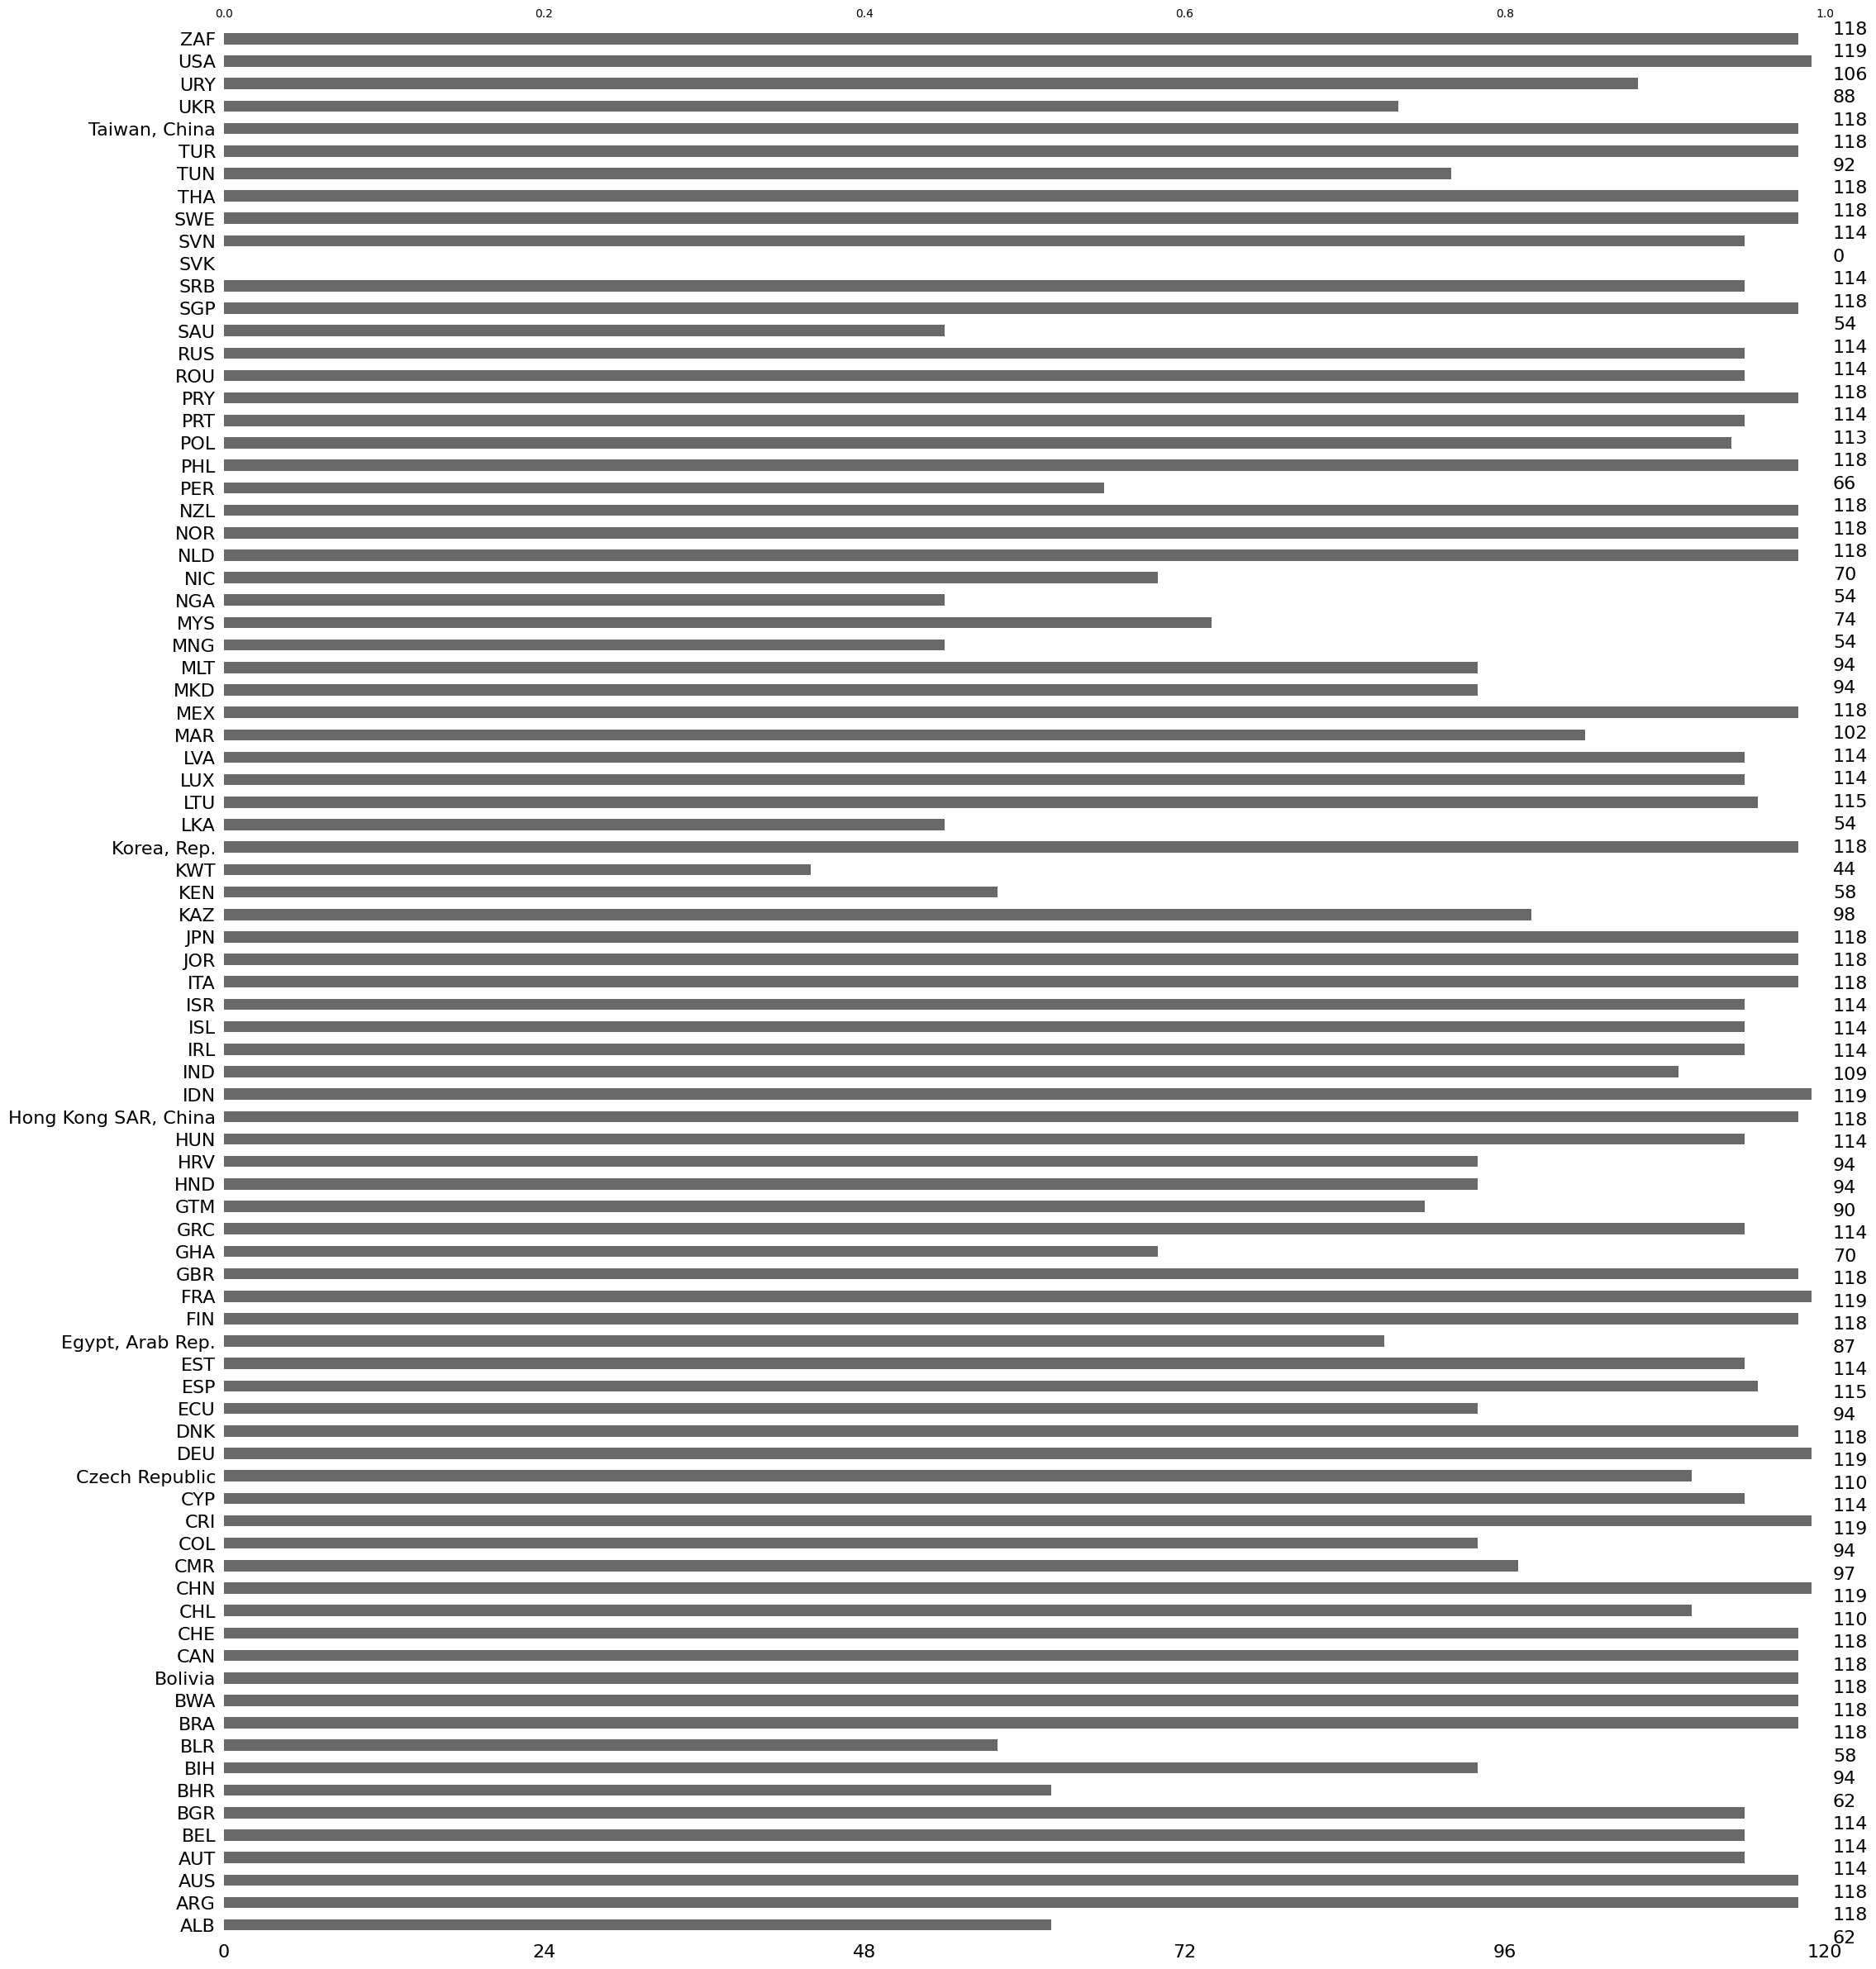

In [30]:
# Diagramme à barres des valeurs manquantes
msno.bar(gdp_filter_sort)
plt.show()

# % des NA

In [31]:
# Calculer le taux de valeurs manquantes
size = gdp_filter_sort.shape
nan_values = gdp_filter_sort.isna().sum()
nan_percent = nan_values.sort_values(ascending=True) * 100 / size[0]
print(nan_percent)

DEU      0.833333
CRI      0.833333
IDN      0.833333
USA      0.833333
CHN      0.833333
          ...    
NGA     55.000000
MNG     55.000000
LKA     55.000000
KWT     63.333333
SVK    100.000000
Length: 85, dtype: float64


# Seuil des NA 

In [32]:
# Récupérer les colonnes avec un pourcentage de valeurs manquantes supérieur à 40%
cols_to_drop = nan_percent[nan_percent > 40].index
print(cols_to_drop)

# Supprimer les colonnes de la DataFrame
gdp_filter_sort.drop(cols_to_drop, axis=1, inplace=True)

Index(['GHA', 'NIC', 'PER', 'ALB', 'BHR', 'BLR', 'KEN', 'SAU', 'NGA', 'MNG',
       'LKA', 'KWT', 'SVK'],
      dtype='object')


In [33]:
# Convertir l'index en type date { Les données sont trimestrielles pour le PIB }
gdp_filter_sort.index = pd.to_datetime(gdp_filter_sort.index)

# Afficher le DataFrame
gdp_filter_sort.head(5)

,ARG,AUS,AUT,BEL,BGR,BIH,BRA,BWA,Bolivia,CAN,...,SVN,SWE,THA,TUN,TUR,"Taiwan, China",UKR,URY,USA,ZAF
1994-01-01,0.635635,0.501645,NaN,NaN,NaN,NaN,0.123187,0.153523,1.467776,0.680429,...,NaN,0.585296,0.767809,NaN,0.006777,0.972158,NaN,NaN,0.650468,0.224378
1994-04-01,0.644039,0.502208,NaN,NaN,NaN,NaN,0.408431,0.155683,1.489281,0.680180,...,NaN,0.587775,0.778599,NaN,0.009421,0.971386,NaN,NaN,0.653595,0.225938
1994-07-01,0.629986,0.513144,NaN,NaN,NaN,NaN,0.736257,0.156721,1.553399,0.686270,...,NaN,0.591138,0.791610,NaN,0.010014,0.975472,NaN,NaN,0.657365,0.227397
1994-10-01,0.633305,0.504920,NaN,NaN,NaN,NaN,0.722830,0.166511,1.613844,0.689810,...,NaN,0.595983,0.809556,NaN,0.012484,0.979225,NaN,NaN,0.660922,0.234643
1995-01-01,0.665618,0.514092,0.727697,0.734561,0.021998,NaN,0.927748,0.167669,1.640577,0.694571,...,0.445624,0.604172,0.826319,NaN,0.015562,0.977918,NaN,NaN,0.664523,0.242769


C:\Users\yousr\AppData\Local\Temp\ipykernel_2120\788178754.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


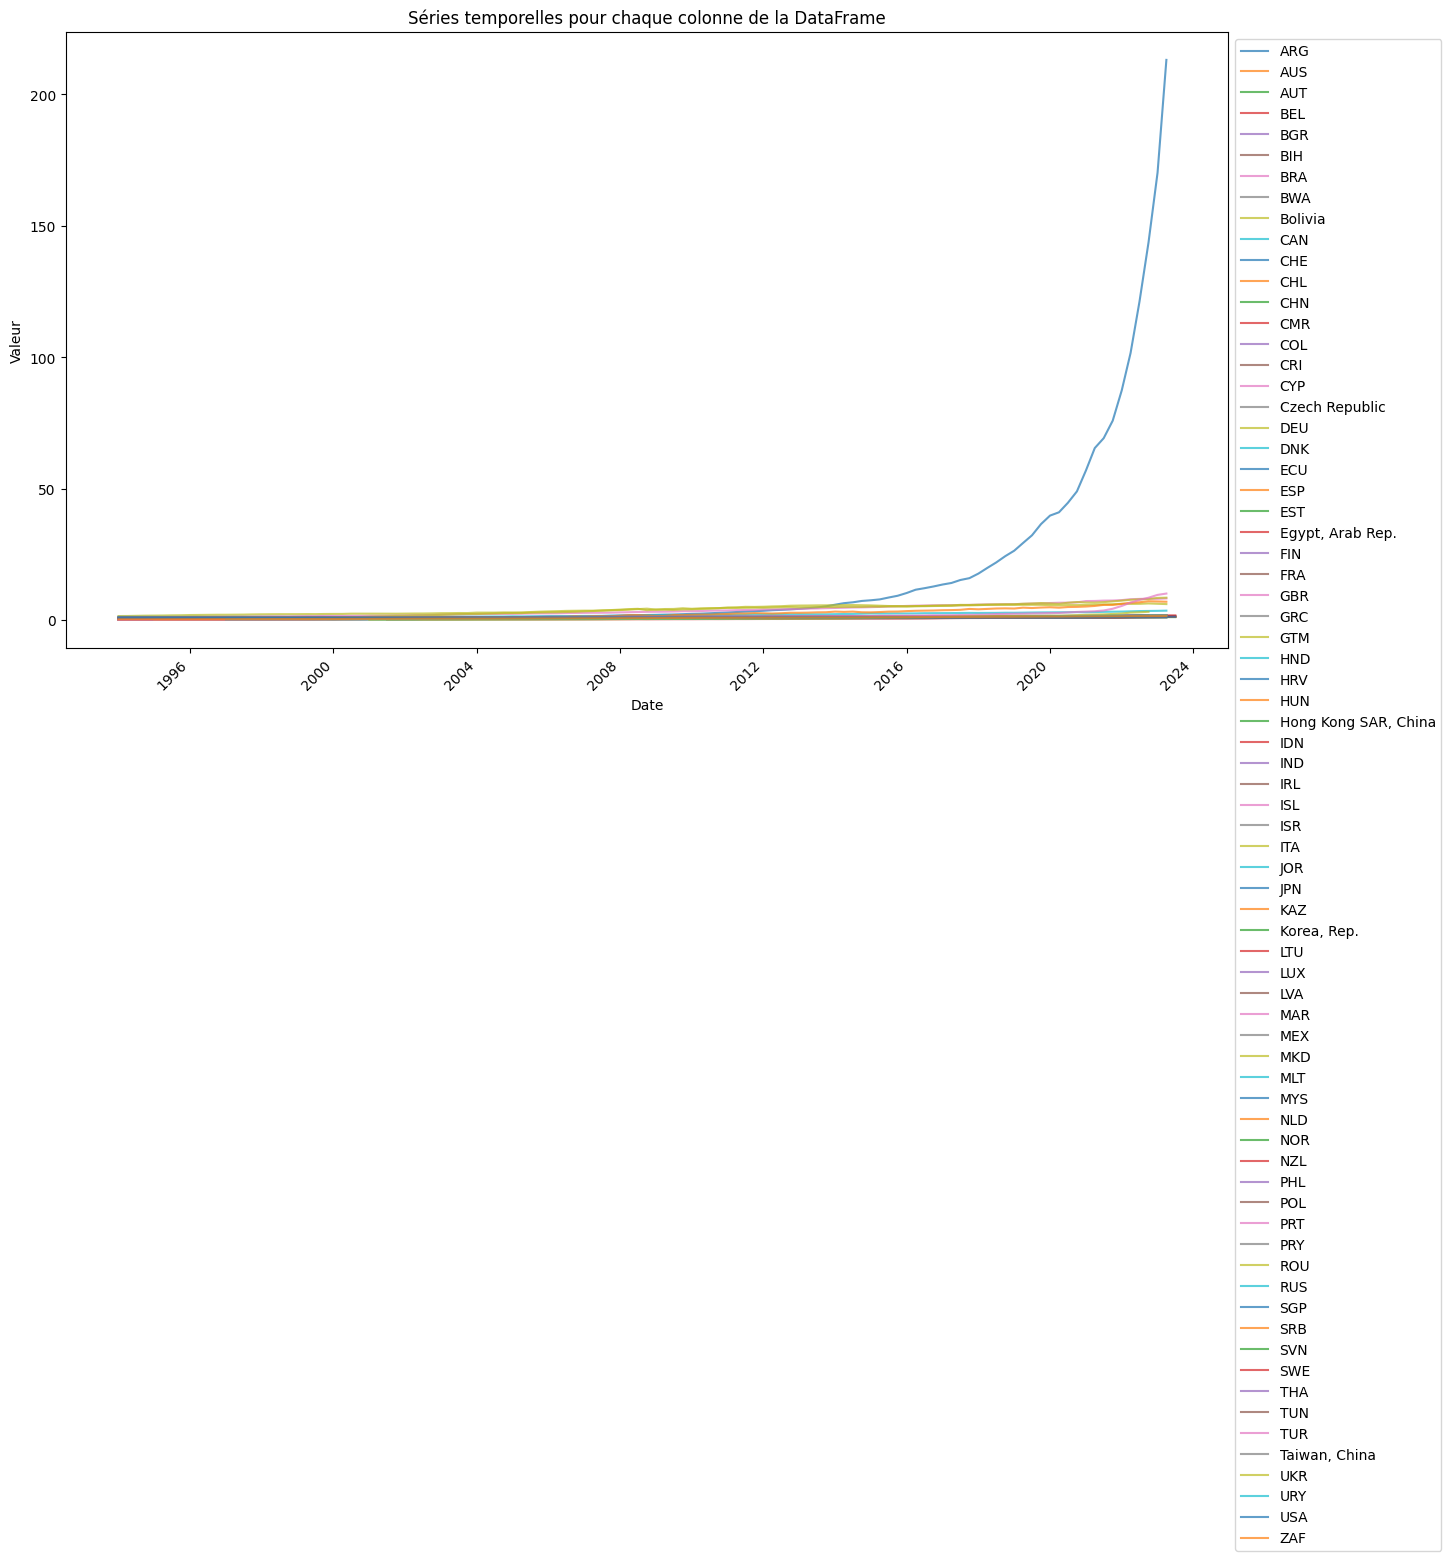

In [34]:
# Graphique de l'évolution du taux de croissance (PIB) par pays sur toute la période

plt.figure(figsize=(15, 8))

for col in gdp_filter_sort.columns:
    plt.plot(gdp_filter_sort.index, gdp_filter_sort[col], label=col, alpha=0.7)

# Ajouter des titres et une légende
plt.title('Séries temporelles pour chaque colonne de la DataFrame')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Faire pivoter les étiquettes de l'axe des x
plt.xticks(rotation=45, ha='right')

# Afficher le graphique
plt.tight_layout()
plt.show()


# Imputation 

In [35]:
# Imputation des valeurs manquantes NA par interpolation

# Interpolation linéaire :

# gdp_filter_sort.interpolate(method='linear', limit=None)

# Interpolation polynômiale d'ordre 3 :

# gdp_filter_sort.interpolate(method='polynomial', order=3, limit=None)
              
gdp_no_na = gdp_filter_sort.fillna(gdp_filter_sort.mean())

In [36]:
# Ignorer les jours dans l'index
gdp_no_na.index =gdp_no_na.index.strftime('%Y-%m')

# BD des taux de croissance par trimestre pour chaque pays

In [37]:
gdp_no_na.head(5) #72 pays

,ARG,AUS,AUT,BEL,BGR,BIH,BRA,BWA,Bolivia,CAN,...,SVN,SWE,THA,TUN,TUR,"Taiwan, China",UKR,URY,USA,ZAF
1994-01,0.635635,0.501645,0.906967,0.920006,0.815213,0.931624,0.123187,0.153523,1.467776,0.680429,...,0.914395,0.585296,0.767809,0.90805,0.006777,0.972158,0.766479,0.735524,0.650468,0.224378
1994-04,0.644039,0.502208,0.906967,0.920006,0.815213,0.931624,0.408431,0.155683,1.489281,0.680180,...,0.914395,0.587775,0.778599,0.90805,0.009421,0.971386,0.766479,0.735524,0.653595,0.225938
1994-07,0.629986,0.513144,0.906967,0.920006,0.815213,0.931624,0.736257,0.156721,1.553399,0.686270,...,0.914395,0.591138,0.791610,0.90805,0.010014,0.975472,0.766479,0.735524,0.657365,0.227397
1994-10,0.633305,0.504920,0.906967,0.920006,0.815213,0.931624,0.722830,0.166511,1.613844,0.689810,...,0.914395,0.595983,0.809556,0.90805,0.012484,0.979225,0.766479,0.735524,0.660922,0.234643
1995-01,0.665618,0.514092,0.727697,0.734561,0.021998,0.931624,0.927748,0.167669,1.640577,0.694571,...,0.445624,0.604172,0.826319,0.90805,0.015562,0.977918,0.766479,0.735524,0.664523,0.242769


# Valeurs abérrantes 

In [38]:
# Les valeurs abérrantes 
# plt.figure(figsize=(10, 6))
"""sns.boxplot(data=gdp_no_na)
plt.title('Boîtes à moustaches des séries temporelles')
plt.show()"""

"sns.boxplot(data=gdp_no_na)\nplt.title('Boîtes à moustaches des séries temporelles')\nplt.show()"

In [39]:
# Définir l'index en tant que date
gdp_no_na.index = pd.to_datetime(gdp_no_na.index, format='%Y-%m')

# Grouper par année et vérifier si tous les trimestres sont présents
gdp_no_na = gdp_no_na.groupby(gdp_no_na.index.year).filter(lambda x: len(x) == 4)
gdp_no_na = pd.DataFrame(gdp_no_na)
gdp_no_na.head(5)

,ARG,AUS,AUT,BEL,BGR,BIH,BRA,BWA,Bolivia,CAN,...,SVN,SWE,THA,TUN,TUR,"Taiwan, China",UKR,URY,USA,ZAF
1994-01-01,0.635635,0.501645,0.906967,0.920006,0.815213,0.931624,0.123187,0.153523,1.467776,0.680429,...,0.914395,0.585296,0.767809,0.90805,0.006777,0.972158,0.766479,0.735524,0.650468,0.224378
1994-04-01,0.644039,0.502208,0.906967,0.920006,0.815213,0.931624,0.408431,0.155683,1.489281,0.680180,...,0.914395,0.587775,0.778599,0.90805,0.009421,0.971386,0.766479,0.735524,0.653595,0.225938
1994-07-01,0.629986,0.513144,0.906967,0.920006,0.815213,0.931624,0.736257,0.156721,1.553399,0.686270,...,0.914395,0.591138,0.791610,0.90805,0.010014,0.975472,0.766479,0.735524,0.657365,0.227397
1994-10-01,0.633305,0.504920,0.906967,0.920006,0.815213,0.931624,0.722830,0.166511,1.613844,0.689810,...,0.914395,0.595983,0.809556,0.90805,0.012484,0.979225,0.766479,0.735524,0.660922,0.234643
1995-01-01,0.665618,0.514092,0.727697,0.734561,0.021998,0.931624,0.927748,0.167669,1.640577,0.694571,...,0.445624,0.604172,0.826319,0.90805,0.015562,0.977918,0.766479,0.735524,0.664523,0.242769


# Jointure entre taux de chomage et PIB par trimestre

In [40]:
print(rate_quart.index)
print(gdp_no_na.index)
print(rate_quart.index.equals(gdp_no_na.index))

Index(['1994-01', '1994-04', '1994-07', '1994-10', '1995-01', '1995-04',
       '1995-07', '1995-10', '1996-01', '1996-04',
       ...
       '2020-10', '2021-01', '2021-04', '2021-07', '2021-10', '2022-01',
       '2022-04', '2022-07', '2022-10', '2023-01'],
      dtype='object', length=117)
DatetimeIndex(['1994-01-01', '1994-04-01', '1994-07-01', '1994-10-01',
               '1995-01-01', '1995-04-01', '1995-07-01', '1995-10-01',
               '1996-01-01', '1996-04-01',
               ...
               '2021-07-01', '2021-10-01', '2022-01-01', '2022-04-01',
               '2022-07-01', '2022-10-01', '2023-01-01', '2023-04-01',
               '2023-07-01', '2023-10-01'],
              dtype='datetime64[ns]', length=120, freq=None)
False


In [41]:
# Fusionner les DataFrames sur l'index en utilisant une jointure interne (how='inner')
common_columns = rate_quart.columns.intersection(gdp_no_na.columns)
print(common_columns)
display(rate_quart.head(1))
display(gdp_no_na.head(1))

Index(['ARG', 'AUS', 'AUT', 'BEL', 'BGR', 'CAN', 'CHE', 'COL', 'CYP',
       'Czech Republic', 'DEU', 'ESP', 'EST', 'Egypt, Arab Rep.', 'FIN', 'FRA',
       'GBR', 'GRC', 'HRV', 'HUN', 'Hong Kong SAR, China', 'IRL', 'ISL', 'ITA',
       'JPN', 'Korea, Rep.', 'LTU', 'LUX', 'LVA', 'MEX', 'MKD', 'MLT', 'NLD',
       'NOR', 'NZL', 'PHL', 'POL', 'PRT', 'ROU', 'RUS', 'SGP', 'SVN', 'SWE',
       'THA', 'TUR', 'Taiwan, China', 'URY', 'USA', 'ZAF'],
      dtype='object')


,ARG,AUS,AUT,BEL,BGR,CAN,CHE,COL,CYP,Czech Republic,...,SVK,SVN,SWE,THA,TUR,"Taiwan, China",URY,USA,"Venezuela, RB",ZAF
1994-01,9.724381,10.58005,6.672157,9.518617,15.86,11.4,4.847199,11.808516,7.71193,4.2,...,14.49,15.1,11.26787,1.380426,10.480357,1.4,9.929305,6.6,10.204788,26.474568


,ARG,AUS,AUT,BEL,BGR,BIH,BRA,BWA,Bolivia,CAN,...,SVN,SWE,THA,TUN,TUR,"Taiwan, China",UKR,URY,USA,ZAF
1994-01-01,0.635635,0.501645,0.906967,0.920006,0.815213,0.931624,0.123187,0.153523,1.467776,0.680429,...,0.914395,0.585296,0.767809,0.90805,0.006777,0.972158,0.766479,0.735524,0.650468,0.224378


In [42]:
# Pour garder uniquement les colonnes présentes dans les deux DF
merged= pd.merge(rate_quart[common_columns], gdp_no_na[common_columns], left_index=True, right_index=True, how='inner' )

In [43]:
merged.head(5)

,ARG_x,AUS_x,AUT_x,BEL_x,BGR_x,CAN_x,CHE_x,COL_x,CYP_x,Czech Republic_x,...,RUS_y,SGP_y,SVN_y,SWE_y,THA_y,TUR_y,"Taiwan, China_y",URY_y,USA_y,ZAF_y


# Exportation de la BD

In [44]:
import pandas as pd
merged.to_excel("Jointure_chomage_pib.xlsx", index=True)

In [45]:
data = pd.read_excel("Jointure_chomage_pib.xlsx")
data.head()

,Unnamed: 0,ARG_x,AUS_x,AUT_x,BEL_x,BGR_x,CAN_x,CHE_x,COL_x,CYP_x,...,RUS_y,SGP_y,SVN_y,SWE_y,THA_y,TUR_y,"Taiwan, China_y",URY_y,USA_y,ZAF_y


In [46]:
#Exemple
merged2 = merged[['ARG_x', 'ARG_y']]
merged2.head()

,ARG_x,ARG_y


# Jointure entre taux de chomage et PIB moyen sur toute la période

In [47]:
mean_rate = pd.DataFrame(rate_quart.mean(), columns=['Taux de chomage'])
mean_gdp = pd.DataFrame(gdp_no_na.mean(), columns=['PIB'])
merged_mean= pd.merge(mean_rate, mean_gdp, left_index=True, right_index=True, how='inner')

In [48]:
merged_mean.head(5)

,Taux de chomage,PIB
ARG,9.772829,14.984950
AUS,6.040780,0.764566
AUT,7.236379,0.906967
BEL,7.775692,0.920006
BGR,10.599188,0.815213


# III. Education

# Importation 

In [49]:
educ=pd.read_excel("C:/Users/yousr/Downloads/Projet_py/BIg_data.xlsx", sheet_name='HNP_StatsData', header=1, index_col=0)
educ.head(5)
col_names=educ.columns
print(col_names)

Index(['Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961',
       '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970',
       '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
       '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988',
       '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020', '2021', '2022', 'Unnamed: 67'],
      dtype='object')


# Life Expectancy

In [50]:
masque = educ['Indicator Name'].str.contains('expectancy', case=False) & educ['Indicator Name'].str.contains('total', case=False)
# Appliquez le masque pour obtenir un nouveau DataFrame avec les lignes filtrées
educ_LE = educ[masque]

In [51]:
# Filtrer les colonnes qui contiennent des années ou les noms des pays
cols_to_keep = educ_LE.columns[educ_LE.columns.str.contains(r'\d{4}|Indicator Name')]

# Créer un nouveau DataFrame avec les colonnes filtrées
educ_LE_col = educ_LE[cols_to_keep]
print(educ_LE_col)

                                                         Indicator Name  \
Country Name                                                              
Africa Eastern and Southern     Life expectancy at birth, total (years)   
Africa Western and Central      Life expectancy at birth, total (years)   
Arab World                      Life expectancy at birth, total (years)   
Caribbean small states          Life expectancy at birth, total (years)   
Central Europe and the Baltics  Life expectancy at birth, total (years)   
...                                                                 ...   
Virgin Islands (U.S.)           Life expectancy at birth, total (years)   
West Bank and Gaza              Life expectancy at birth, total (years)   
Yemen, Rep.                     Life expectancy at birth, total (years)   
Zambia                          Life expectancy at birth, total (years)   
Zimbabwe                        Life expectancy at birth, total (years)   

                        

In [52]:
educ_LE_col = educ_LE_col.drop(columns="Indicator Name")
mean_LE = educ_LE_col.mean(axis=1)

In [53]:
mean_LE =mean_LE.to_frame(name='Life Expectancy')

# Population growth rate

In [54]:
masque1 = educ['Indicator Name'].str.contains('Population growth ', case=False)
educ_PGR = educ[masque1]

In [55]:
# Filtrer les colonnes qui contiennent des années ou les noms des pays
cols_to_keep1 = educ_PGR.columns[educ_PGR.columns.str.contains(r'\d{4}|Indicator Name')]

# Créer un nouveau DataFrame avec les colonnes filtrées
educ_PGR_filter1 = educ_PGR[cols_to_keep1]
print(educ_PGR_filter1)

                                                 Indicator Name  1960  \
Country Name                                                            
Africa Eastern and Southern        Population growth (annual %)   NaN   
Africa Eastern and Southern  Rural population growth (annual %)   NaN   
Africa Eastern and Southern  Urban population growth (annual %)   NaN   
Africa Western and Central         Population growth (annual %)   NaN   
Africa Western and Central   Rural population growth (annual %)   NaN   
...                                                         ...   ...   
Zambia                       Rural population growth (annual %)   NaN   
Zambia                       Urban population growth (annual %)   NaN   
Zimbabwe                           Population growth (annual %)   NaN   
Zimbabwe                     Rural population growth (annual %)   NaN   
Zimbabwe                     Urban population growth (annual %)   NaN   

                                 1961      1962   

In [56]:
unique = educ_PGR_filter1['Indicator Name'].unique()
print(unique)

# On souhaite garder que le taux de croissance de la population totale

# Par élimination successive
# On garde les lignes où il y a le taux de croissance du milieu hors que urbain
masque2 = educ_PGR_filter1['Indicator Name'].str.contains('urban', case=False)
masque2_inverse= ~masque2 # Récupérer les lignes qui ne vérifient pas le masque
educ_PGR_filter2 = educ_PGR_filter1[masque2_inverse]

# On garde les lignes où il y a le taux de croissance du milieu hors que rural
masque3 = educ_PGR_filter2['Indicator Name'].str.contains('rural', case=False)
masque3_inverse = ~masque3
educ_PGR_filter3 = educ_PGR_filter2[masque3_inverse]

['Population growth (annual %)' 'Rural population growth (annual %)'
 'Urban population growth (annual %)']


In [57]:
educ_PGR_filter3  = educ_PGR_filter3.drop(columns="Indicator Name")
mean_PGR = educ_PGR_filter3.mean(axis=1)

In [58]:
mean_PGR=mean_PGR .to_frame(name='Life Expectancy')

# IV. GMD Inégalités

# Importation des packages

In [59]:
import pycodestyle as pep8
import openpyxl as xl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycountry
np.random.seed(123)

# Importation de la BD

In [60]:
# Gini Mean Difference
gmd=pd.read_excel("C:/Users/yousr/Downloads/Projet_py/inequality GMD World Bank.xlsx",  sheet_name='data', index_col=0)
gmd.head(5)
col_names=gmd.columns
print(col_names)

Index(['countrycode', 'countryname', 'region', 'year', 'regionname',
       'incomelevelname', 'lendingtypename', 'index', 'between', 'within',
       'noregion', 'nobs', 'minwelfare_median', 'maxwelfare_median',
       'minwelfare_mean', 'maxwelfare_mean', 'minwelfare_b1', 'maxwelfare_b1',
       'minwelfare_t1', 'maxwelfare_t1', 'ineq', 'withinreg',
       'ny_gdp_pcap_pp_kd', 'sp_urb_totl_in_zs', 'sp_pop_totl',
       'en_urb_lcty_ur_zs', 'si_pov_lmic', 'loggdp', 'logpop'],
      dtype='object')


# Extraction des colonnes nécessaires

In [61]:
# Base de données de l'indice Theil
theil = gmd.pivot(index='year', columns='countryname', values='index')
theil.head(5)

countryname,NaN,Albania,Angola,Argentina,Armenia,Azerbaijan,Bangladesh,Belarus,Benin,Bhutan,...,Uganda,Ukraine,United Kingdom,Uruguay,Vanuatu,Vietnam,"Yemen, Rep","Yemen, Rep.",Zambia,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
2000,NaN,NaN,NaN,NaN,NaN,NaN,0.218332,0.167268,NaN,NaN,...,NaN,NaN,NaN,0.329947,NaN,NaN,NaN,NaN,NaN,NaN
2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.165881,NaN,NaN,...,NaN,NaN,NaN,0.362808,NaN,NaN,NaN,NaN,NaN,NaN
2002,NaN,NaN,NaN,NaN,NaN,0.128037,NaN,0.166370,NaN,NaN,...,NaN,NaN,NaN,0.373531,NaN,NaN,NaN,NaN,NaN,NaN
2003,NaN,NaN,NaN,0.530321,NaN,0.138202,NaN,0.141218,NaN,0.337396,...,NaN,NaN,NaN,0.369967,NaN,NaN,NaN,NaN,NaN,NaN
2004,NaN,NaN,NaN,0.426397,NaN,NaN,NaN,0.116589,NaN,NaN,...,NaN,NaN,NaN,0.385881,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# La moyenne de l'indice de theil sur toutes les périodes
mean_theil = theil.mean(axis=0) 

In [63]:
# Base de données du taux d'urbanisation
urban = gmd.pivot(index='year', columns='countryname', values='sp_urb_totl_in_zs')
urban.head(5)

countryname,NaN,Albania,Angola,Argentina,Armenia,Azerbaijan,Bangladesh,Belarus,Benin,Bhutan,...,Uganda,Ukraine,United Kingdom,Uruguay,Vanuatu,Vietnam,"Yemen, Rep","Yemen, Rep.",Zambia,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
2000,NaN,NaN,NaN,NaN,NaN,NaN,23.59,69.973,NaN,NaN,...,NaN,NaN,NaN,92.028,NaN,NaN,NaN,NaN,NaN,NaN
2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.458,NaN,NaN,...,NaN,NaN,NaN,92.303,NaN,NaN,NaN,NaN,NaN,NaN
2002,NaN,NaN,NaN,NaN,NaN,51.787,NaN,70.939,NaN,NaN,...,NaN,NaN,NaN,92.569,NaN,NaN,NaN,NaN,NaN,NaN
2003,NaN,NaN,NaN,89.686,NaN,51.988,NaN,71.415,NaN,28.688,...,NaN,NaN,NaN,92.828,NaN,NaN,NaN,NaN,NaN,NaN
2004,NaN,NaN,NaN,89.860,NaN,NaN,NaN,71.887,NaN,NaN,...,NaN,NaN,NaN,93.078,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# La moyenne du taux d'urbanisation sur toutes les périodes
mean_urban = urban.mean(axis=0)

In [65]:
# Base de données du ratio de pauvreté
poverty = gmd.pivot(index='year', columns='countryname', values='si_pov_lmic')
poverty.head(5)

countryname,NaN,Albania,Angola,Argentina,Armenia,Azerbaijan,Bangladesh,Belarus,Benin,Bhutan,...,Uganda,Ukraine,United Kingdom,Uruguay,Vanuatu,Vietnam,"Yemen, Rep","Yemen, Rep.",Zambia,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
2000,NaN,NaN,NaN,NaN,NaN,NaN,72.3,27.8,NaN,NaN,...,NaN,NaN,NaN,2.1,NaN,NaN,NaN,NaN,NaN,NaN
2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.6,NaN,NaN,...,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN
2002,NaN,NaN,NaN,NaN,NaN,0.6,NaN,11.4,NaN,NaN,...,NaN,NaN,NaN,3.3,NaN,NaN,NaN,NaN,NaN,NaN
2003,NaN,NaN,NaN,17.3,NaN,0.9,NaN,9.4,NaN,45.3,...,NaN,NaN,NaN,4.4,NaN,NaN,NaN,NaN,NaN,NaN
2004,NaN,NaN,NaN,13.9,NaN,NaN,NaN,4.7,NaN,NaN,...,NaN,NaN,NaN,5.8,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
# La moyenne du ratio de pauvreté sur toutes les périodes
mean_poverty = poverty.mean(axis=0)

In [67]:
# Dans pandas, une Df à une colonne correspond à une série. On donne un nom à chaque série pour une éventuelle jointure
mean_poverty.name = 'Ratio de pauvreté'
mean_urban.name = "Taux urbanisation"
mean_theil.name = 'Theil'

# Jointure 

In [68]:
# Jointure entre df1 et df2 sur la colonne "countryname"
merged1 = pd.merge(mean_poverty, mean_urban, on='countryname', how='inner')
# Jointure entre le résultat précédent (merged_df) et df3 sur la colonne "countryname"
final_merged1 = pd.merge(merged1, mean_theil, on='countryname', how='inner')

In [69]:
# Dans pandas, une Df à une colonne correspond à une série. On donne un nom à chaque série pour une éventuelle jointure
mean_LE.name = 'Espérance de vie'
mean_PGR.name = "Croissance démo"

In [70]:
final_merged1.index.name = 'Country Name'  ####################################################################################
mean_LE.index.name = 'Country Name'
mean_PGR.index.name = 'Country Name'
merged_mean.index.name = 'Country Name'

In [71]:
# Jointure entre df1 et df2 sur la colonne "countryname"
merged2 = pd.merge(final_merged1, mean_PGR, on='Country Name', how='inner')
# Jointure entre le résultat précédent (merged_df) et df3 sur la colonne "countryname"
merged3 = pd.merge(merged2, mean_LE, on='Country Name', how='inner')

# Transposé de merged3

In [72]:
merged3_transpose = merged3.transpose()
col_names = merged3_transpose.columns
merged3_transpose.head(5)

Country Name,Albania,Angola,Argentina,Armenia,Azerbaijan,Bangladesh,Belarus,Benin,Bhutan,Bolivia,...,Tunisia,Uganda,Ukraine,United Kingdom,Uruguay,Vanuatu,Vietnam,"Yemen, Rep.",Zambia,Zimbabwe
Ratio de pauvreté,8.820000,66.050000,6.720000,8.750000,0.500000,62.600000,3.968421,76.200000,25.700000,20.925000,...,9.133333,68.450000,0.380000,0.325000,2.115789,39.400000,22.850000,51.200000,78.100000,61.000000
Taux urbanisation,54.667800,61.898000,90.813067,63.126000,52.054667,28.986000,74.264895,45.695000,34.423750,66.259583,...,66.650000,21.524000,68.899200,82.228875,93.998947,24.462000,30.793000,34.165000,40.631000,32.237000
Theil,0.218051,0.473635,0.357096,0.249318,0.136647,0.205326,0.134025,0.439539,0.281611,0.504476,...,0.220403,0.350804,0.111606,0.207105,0.336487,0.265961,0.241415,0.254696,0.623474,0.379988
Life Expectancy_x,0.879662,3.054187,1.323653,0.610621,1.548984,1.972311,0.187514,2.694417,2.037211,1.924272,...,1.742172,2.943489,-0.190623,0.395741,0.488105,2.614236,1.772472,2.911224,2.998331,2.348007
Life Expectancy_y,71.500903,46.675645,71.077355,68.278145,63.571306,57.988419,70.489206,51.336548,54.910452,56.434871,...,66.254468,50.176048,69.270562,76.046558,72.932097,63.650258,67.586306,54.784113,52.337758,54.743532


# Code ISO des pays

In [73]:
# Pour faciliter la lecture de la DF, on remplace les noms des pays par leurs codes ISO  correspondant

# Dictionnaire de correspondance entre noms complets des pays et leurs codes
corresp = {country.name: country.alpha_3 for country in pycountry.countries}

# Liste initiale des noms complets des colonnes
country = col_names
# Transformation des noms complets des colonnes en abréviations
country_codes = [corresp.get(pays, pays) for pays in country]

# Remplacement des noms des pays par leurs codes dans la merged
merged3_transpose.columns=country_codes
merged3_transpose.columns
merged3_transpose.head(5)

#Ordre alphabétique des colonnes 
merged3_transpose_sort= merged3_transpose.sort_index(axis=1)
merged3_transpose_sort.head(5)

,AGO,ALB,ARG,ARM,AZE,BDI,BEN,BFA,BGD,BLR,...,Tanzania,UGA,UKR,URY,VUT,Vietnam,"Yemen, Rep.",ZAF,ZMB,ZWE
Ratio de pauvreté,66.050000,8.820000,6.720000,8.750000,0.500000,91.350000,76.200000,79.250000,62.600000,3.968421,...,79.500000,68.450000,0.380000,2.115789,39.400000,22.850000,51.200000,36.450000,78.100000,61.000000
Taux urbanisation,61.898000,54.667800,90.813067,63.126000,52.054667,10.549500,45.695000,25.506500,28.986000,74.264895,...,31.287000,21.524000,68.899200,93.998947,24.462000,30.793000,34.165000,63.265000,40.631000,32.237000
Theil,0.473635,0.218051,0.357096,0.249318,0.136647,0.219376,0.439539,0.278554,0.205326,0.134025,...,0.293895,0.350804,0.111606,0.336487,0.265961,0.241415,0.254696,0.784925,0.623474,0.379988
Life Expectancy_x,3.054187,0.879662,1.323653,0.610621,1.548984,2.493621,2.694417,2.509817,1.972311,0.187514,...,3.024506,2.943489,-0.190623,0.488105,2.614236,1.772472,2.911224,2.077381,2.998331,2.348007
Life Expectancy_y,46.675645,71.500903,71.077355,68.278145,63.571306,48.350194,51.336548,48.524387,57.988419,70.489206,...,52.950484,50.176048,69.270562,72.932097,63.650258,67.586306,54.784113,59.196661,52.337758,54.743532


In [74]:
merged4=merged3_transpose.transpose()
merged4.index.name= 'Country Name'
merged4.head(5)

,Ratio de pauvreté,Taux urbanisation,Theil,Life Expectancy_x,Life Expectancy_y
Country Name,,,,,
ALB,8.82,54.667800,0.218051,0.879662,71.500903
AGO,66.05,61.898000,0.473635,3.054187,46.675645
ARG,6.72,90.813067,0.357096,1.323653,71.077355
ARM,8.75,63.126000,0.249318,0.610621,68.278145
AZE,0.50,52.054667,0.136647,1.548984,63.571306


In [75]:
final_merged= pd.merge(merged4, merged_mean, on='Country Name', how='inner')